In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

from scipy.optimize import minimize
from scipy.signal import argrelmin

In [244]:
T = 0.03
beta = 1/T

# The discretized values of omega
omega = np.linspace(-10, 10, 100000, dtype = complex)

# The Matsubara frequencies
max_freq = 3
n_freq = int(((max_freq * beta / np.pi) - 1) / 2) + 1
matsu_freq = (2 * np.array(range(-n_freq, n_freq), dtype = complex) + 1) * np.pi / beta

# The small delta
delta = 1e-3

In [189]:
# Plots complex array by showing real and imaginary parts
def plot_complex(a, is_matsu = True):
    
    fig, ax = plt.subplots(1,2, figsize = (10,4))
    if is_matsu:
        ax[0].plot(np.real(matsu_freq), np.real(a))
        ax[1].plot(np.real(matsu_freq), np.imag(a))
    else:
        ax[0].plot(np.real(omega), np.real(a))
        ax[1].plot(np.real(omega), np.imag(a))
    ax[0].set_title("Real Part")
    ax[1].set_title("Imaginary Part")

We retrieve the parameters $\{V_k, \epsilon_k\}_k$ of the Anderson impurity model from the hybridization function:

$$\Delta(\omega) = \sum_k \frac{V_k^2}{\omega - \epsilon_k + i\delta}$$

We place ourselves at half-filling so that $\mu = \frac U2$, and the AIM hamiltonian reads:

$$H = U n_\uparrow n_\downarrow - \frac U 2 (n_\uparrow + n_\downarrow) + \sum_{k,\sigma} \epsilon_k a_{k,\sigma}^\dagger a_{k,\sigma} + \sum_{k,\sigma} V_k (a_{k,\sigma}^\dagger c_\sigma + c_\sigma^\dagger a_{k,\sigma})$$

where $a_{k,\sigma}^\dagger$ denotes the creation operator of an electron in the bath, $c_\sigma^\dagger$ denotes the creation operator of the impurity electron and $n_\sigma = c_\sigma^\dagger c_\sigma$.

### Retrieval of the hamiltonian parameters

$\Delta(\omega)$ is represented as an array of complex numbers corresponding to different values of $\omega$. We recover the hamiltonian parameters $\{V_k, \epsilon_k\}_k$ by optimizing a function:

$$f : \{V_k, \epsilon_k\}_k \to \Delta(\omega) $$

against the real $\Delta(\omega)$.

To obtain an initial guess, we use the fact that the local minima of $\Im (\Delta(\omega))$ are the $\epsilon_k$ and that close to $\epsilon_k$, its contribution will dominate so that:

$$V_k^2 \approx - \delta \Im (\Delta(\epsilon_k))$$

In [144]:
def hybridizationFunction(V, e):
    n = len(V)
    s = omega * 0
    for k in range(n):
        s += V[k]**2 / (omega - e[k] + 1.j * delta)
    return s

def hamParameters(hyb_func, n_k, verbose = False):
    
    # The format of the argument of optimize_me is V_i, e_i
    def optimize_me(args):
        n = len(args)
        V = args[:n//2]
        e = args[n//2:]
        return np.linalg.norm(hyb_func - hybridizationFunction(V, e))
    
    # Obtain initial guess
    
    # The energies are the minimums of the imaginary part
    e_ini = np.real(omega[argrelmin(np.imag(hyb_func))])
    
    # The V_k are approximately sqrt(delta ** 2 * hyb_func(e_k)
    V_ini = np.sqrt(-delta * np.imag(hyb_func)[argrelmin(np.imag(hyb_func))[0]])
    
    args_ini = np.zeros(2 * n_k)
    args_ini[:n_k] = V_ini
    args_ini[n_k:] = e_ini
    
    if verbose:
        print(optimize_me(args_ini))
        print("\nV_ini: ")
        print(V_ini)
        print("\ne_ini: ")
        print(e_ini)
    
    # minimize optimize_me based on the initial guess
    res = minimize(optimize_me, args_ini, method = 'BFGS')
    V = res.x[:n_k]
    e = res.x[n_k:]
    return V, e, res.fun

In [145]:
# Check that it works properly

n_k = 4
V = [9.3, 12.1, 2.1, 5.5]
e = [-3,-7,9,4]

hyb_func = hybridizationFunction(V, e)
hamParameters(hyb_func, n_k)

(array([12.09999559,  9.30000403,  5.4999936 ,  2.09997706]),
 array([-7.00000001, -3.        ,  4.        ,  9.00000002]),
 2.581014680362732)

In [149]:
# Same thing but with Matsubara frequencies

def matsuHybridizationFunction(V, e):
    n = len(V)
    s = matsu_freq * 0
    for k in range(n):
        s += V[k]**2 / (1.j * matsu_freq - e[k])
    return s

def matsuHamParameters(matsu_hyb_func, n_k):
    
    # The format of the argument of matsu_optimize_me is V_i, e_i
    def matsu_optimize_me(args):
        n = len(args)
        V = args[:n//2]
        e = args[n//2:]
        return np.linalg.norm(matsu_hyb_func - matsuHybridizationFunction(V, e)) ** 2
    
    args_ini = np.zeros(2 * n_k)
    
    # minimize matsu_optimize_me
    res = minimize(matsu_optimize_me, args_ini, method = 'Powell')
    V = res.x[:n_k]
    e = res.x[n_k:]
    return V, e, res.fun

In [152]:
# Check that it works properly

n_k = 3
V = [3.6, 2.3, 8.1]
e = [-2.1, 1.1, -3.1]

matsu_hyb_func = matsuHybridizationFunction(V, e)
matsuHamParameters(matsu_hyb_func, n_k)

(array([1.08964136, 8.78358308, 2.29525185]),
 array([-1.07633155, -2.93512967,  1.09629472]),
 0.032712673692940744)

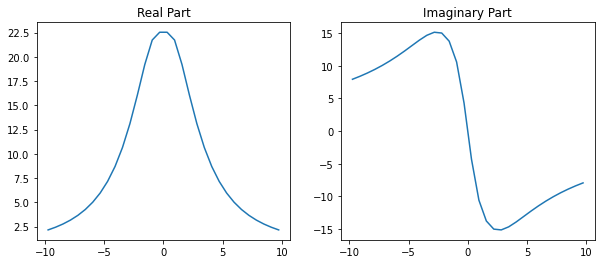

In [153]:
plot_complex(matsu_hyb_func)

### Constructing the hamiltonian

Using the hamiltonian parameters $\{V_k, \epsilon_k\}_k$, we can now construct the hamiltonian. We use the following convention indexing the sites with $i$:
- If $i$ is even, the site has spin up
- If $i$ is odd, the site has spin down
- $i//2 = 0$ indicates the impurity site
- $i//2 = k > 0$ indicates site k - 1

For example 100100 indicates that the spin up impurity site and the spin down first bath level are filled.

In [225]:
def AIM(V, e, U):
    
    # Number of sites in the bath
    nk = len(V)
    
    # Total number of sites
    n = 2 * (nk + 1)
    
    # Impurity on-site interaction
    prod = [qeye(2) for x in range(n)]
    prod[0] = num(2)
    prod[1] = num(2)
    H1 = U * tensor(prod)
    
    # Impurity chemical potential
    prod = [qeye(2) for x in range(n)]
    prod[0] = num(2)
    H2 = - (U/2) * tensor(prod)
    prod = [qeye(2) for x in range(n)]
    prod[1] = num(2)
    H2 += - (U/2) * tensor(prod)
    
    # Bath energy levels
    H3 = H1 * 0
    for k in range(nk):
        for spin in range(2):
            prod = [qeye(2) for x in range(n)]
            prod[2*(k + 1) + spin] = num(2)
            H3 += e[k] * tensor(prod)
    
    # Bath-impurity interaction
    H4 = H1 * 0
    for k in range(nk):
        for spin in range(2):
            
            prod = [qeye(2) for x in range(n)]
            prod[spin] = destroy(2)
            prod[2*(k + 1) + spin] = create(2)
            H4 += V[k] * tensor(prod)
            
            prod = [qeye(2) for x in range(n)]
            prod[spin] = create(2)
            prod[2*(k + 1) + spin] = destroy(2)
            H4 += V[k] * tensor(prod)
            
    return H1 + H2 + H3 + H4

In [147]:
H = AIM([2,4], [3, 7], 1)
H

Quantum object: dims = [[2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2]], shape = (64, 64), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  7.  0. ...  0.  0.  0.]
 [ 0.  0.  7. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 13.  0.  0.]
 [ 0.  0.  0. ...  0. 13.  0.]
 [ 0.  0.  0. ...  0.  0. 20.]]

In [148]:
H[int('001001', 2), int('101000', 2)]

0j

In [149]:
# Returns the spin up impurity green's function given the hamiltonian

def impurity_green(H, T):
    
    beta = 1/T
    
    # Get the eigendecomposition
    eigvals, eigvecs = np.linalg.eigh(H._data.todense())
    n = len(eigvals)
    
    # The partition function
    Z = np.sum(np.exp(-beta * eigvals))
    
    # Green's function
    G = 0
    for i in range(n):
        for j in range(n):
            
            ei = eigvecs[:,i].copy()
            ej = eigvecs[:,j].copy()
            
            # Computing c^dagger|j>
            ej[n//2:] = ej[:n//2]
            ej[:n//2] = 0
            
            prob = (ei.H @ ej)[0,0]
            
            G += prob * (np.exp(-beta * eigvals[i]) + np.exp(-beta * eigvals[j])) / (omega + eigvals[j] - eigvals[i] + 1.j * delta)
    
    return G / Z

In [155]:
# Returns the spin up impurity green's function with Matsubara frequencies given the hamiltonian

def matsu_impurity_green(H, T):
    
    beta = 1/T
    
    # Get the eigendecomposition
    eigvals, eigvecs = np.linalg.eigh(H._data.todense())
    n = len(eigvals)
    
    # The partition function
    Z = np.sum(np.exp(-beta * eigvals))
    
    # Green's function
    G = 0
    for i in range(n):
        for j in range(n):
            
            ei = eigvecs[:,i].copy()
            ej = eigvecs[:,j].copy()
            
            # Computing c^dagger|j>
            ej[n//2:] = ej[:n//2]
            ej[:n//2] = 0
            
            prob = (ei.H @ ej)[0,0]
            
            G += prob * (np.exp(-beta * eigvals[i]) + np.exp(-beta * eigvals[j])) / (1.j * matsu_freq + eigvals[j] - eigvals[i])
    
    return G / Z

In [150]:
# Returns the spin up impurity green's function given the hybridization function

def loopstep(hyb_func, n_k, U, T):
    V, e, val = hamParameters(hyb_func, n_k)
    H = AIM(V, e, U)
    G = impurity_green(H, T)
    return G

In [228]:
# Returns the spin up impurity green's function given the hybridization function

def matsu_loopstep(matsu_hyb_func, n_k, U, T, verbose = False):
    print("Retrieving hamiltonian parameters")
    V, e, val = matsuHamParameters(matsu_hyb_func, n_k)
    print("Optimization MSE: {:.4}".format(val))
    H = AIM(V, e, U)
    print("Computing green's function\n")
    G = matsu_impurity_green(H, T)
    return G

# DMFT loop

We work on the Bethe lattice for a simplified loop: $\Delta(\omega) = t^2 G_\text{imp}$

We start with $$\Delta_0(\omega) = \frac{\omega - \sqrt{\omega^2 - 4t^2}}{2t^2}$$
or $$\Delta_0(i\omega_n) = \frac{i\omega_n - \sqrt{-\omega_n^2 - 4t^2}}{2t^2} = \frac{i\omega_n \pm i\sqrt{\omega_n^2 + 4t^2}}{2t^2}$$

In [219]:
# In real frequency

# T was defined above
n_k = 2
U = 1

hyb_func = - np.sign(np.real(omega)) * (omega - (omega ** 2 - 4) ** 0.5)

for k in range(3):
    print("Step {}".format(k + 1))
    hyb_func = loopstep(hyb_func, n_k, U, T)

'for k in range(3):\n    print("loop")\n    hyb_func = loopstep(hyb_func, n_k, U, T)'

In [246]:
# In Matsubara frequency

# T was defined above
n_k = 2
U = 1

matsu_hyb_func = - np.sign(np.real(matsu_freq)) * (1.j * matsu_freq + 1.j * (matsu_freq ** 2 + 4))

for k in range(3):
    print("Step {}".format(k + 1))
    matsu_hyb_func = matsu_loopstep(matsu_hyb_func, n_k, U, T)

print("Done")

Step 1
Retrieving hamiltonian parameters
Optimization MSE: 158.7
Computing green's function



C:\Users\Adrien\AppData\Local\Temp/ipykernel_14704/4213582834.py:12: RuntimeWarning: overflow encountered in exp
  Z = np.sum(np.exp(-beta * eigvals))
C:\Users\Adrien\AppData\Local\Temp/ipykernel_14704/4213582834.py:28: RuntimeWarning: overflow encountered in exp
  G += prob * (np.exp(-beta * eigvals[i]) + np.exp(-beta * eigvals[j])) / (1.j * matsu_freq + eigvals[j] - eigvals[i])
C:\Users\Adrien\AppData\Local\Temp/ipykernel_14704/4213582834.py:28: RuntimeWarning: invalid value encountered in cdouble_scalars
  G += prob * (np.exp(-beta * eigvals[i]) + np.exp(-beta * eigvals[j])) / (1.j * matsu_freq + eigvals[j] - eigvals[i])
C:\Users\Adrien\AppData\Local\Temp/ipykernel_14704/4213582834.py:28: RuntimeWarning: invalid value encountered in true_divide
  G += prob * (np.exp(-beta * eigvals[i]) + np.exp(-beta * eigvals[j])) / (1.j * matsu_freq + eigvals[j] - eigvals[i])


Step 2
Retrieving hamiltonian parameters
Optimization MSE: nan
Computing green's function

Step 3
Retrieving hamiltonian parameters
Optimization MSE: 4.914
Computing green's function

Done


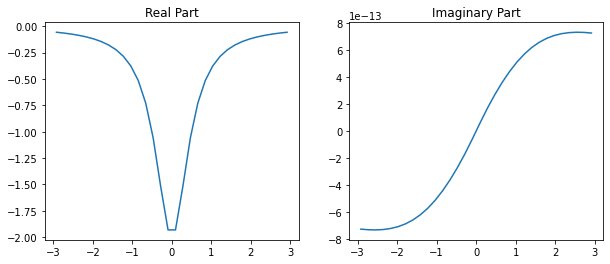

In [247]:
#matsu_hyb_func = - (1.j * matsu_freq + 1.j * (matsu_freq ** 2 + 4))
plot_complex(matsu_hyb_func, is_matsu = True)

In [243]:
matsuHamParameters(matsu_hyb_func, n_k)

(array([0.35021879, 0.21150638]),
 array([-0.69164003, -7.53920572]),
 0.0018337681305730588)